In [ ]:
%matplotlib inline

from collections import defaultdict
from IPython import display
from PIL import Image
from torch import nn
from torch.autograd import Variable
from torchvision import models, transforms

import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch

# Data Acquisition

For this assignment, you must download the dataset provided as a separate link on the course webpage and extract it into `data/`. The dataset contains approximately 20K training images and 100 validation images, with multiple captions/tags for each image. For this assignment, we are only concerned with the tags and ignore the captions.

For question two on the assignment, the dataset also contains a JSON file that maps from the ImageNet labels to the category names. 

Following the data downloading and unzipping, the code below loads in the data into memory accordingly.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
!unzip /content/drive/MyDrive/Colab_Notebooks/data.zip

In [ ]:
# Define a global transformer to appropriately scale images and subsequently convert them to a Tensor.
img_size = 224
loader = transforms.Compose([
  transforms.Resize(img_size),
  transforms.CenterCrop(img_size),
  transforms.ToTensor(),
]) 
def load_image(filename):
    """
    Simple function to load and preprocess the image.

    1. Open the image.
    2. Scale/crop it and convert it to a float t
    ensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    image = Image.open(filename).convert('RGB')
    image_tensor = loader(image).float()
    #
    image_var = Variable(image_tensor).unsqueeze(0)
    #return image_var.cuda()
    #print( image_var.size())
    return image_var
    

load_image('data/train2014/COCO_train2014_000000000009.jpg')
#the size of one image is 
#torch.Size([3, 224, 224])

tensor([[[[0.0039, 0.0078, 0.0039,  ..., 0.0471, 0.0471, 0.0314],
          [0.0039, 0.0039, 0.0039,  ..., 0.0353, 0.0353, 0.0392],
          [0.0039, 0.0039, 0.0039,  ..., 0.0392, 0.0392, 0.0510],
          ...,
          [0.7137, 0.7294, 0.7137,  ..., 0.1686, 0.1843, 0.1686],
          [0.7059, 0.6902, 0.6863,  ..., 0.1765, 0.1804, 0.2039],
          [0.6784, 0.6667, 0.6706,  ..., 0.1922, 0.2157, 0.2275]],

         [[0.1490, 0.1490, 0.1412,  ..., 0.0039, 0.0039, 0.0039],
          [0.1451, 0.1412, 0.1373,  ..., 0.0039, 0.0039, 0.0039],
          [0.1412, 0.1373, 0.1373,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.4392, 0.4667, 0.4549,  ..., 0.2588, 0.2745, 0.2863],
          [0.4353, 0.4235, 0.4196,  ..., 0.2745, 0.2980, 0.3137],
          [0.4118, 0.4000, 0.4000,  ..., 0.3020, 0.3176, 0.3020]],

         [[0.5294, 0.5294, 0.5294,  ..., 0.1451, 0.1412, 0.1333],
          [0.5255, 0.5333, 0.5373,  ..., 0.1725, 0.1451, 0.1412],
          [0.5373, 0.5490, 0.5451,  ..., 0

In [ ]:
# Load ImageNet label to category name mapping.
imagenet_categories = [value for key,value in sorted(json.load(open('data/imagenet_categories.json')).items(), key=lambda t: int(t[0]))]

# Load annotations file for the 20K training images.
mscoco_train = json.load(open('data/annotations/train2014.json'))
train_ids = [entry['id'] for entry in mscoco_train['images']]
train_id_to_file = {entry['id']: 'data/train2014/' + entry['file_name'] for entry in mscoco_train['images']}
category_to_name = {entry['id']: entry['name'] for entry in mscoco_train['categories']}
category_idx_to_name = [entry['name'] for entry in mscoco_train['categories']]
category_to_idx = {entry['id']: i for i,entry in enumerate(mscoco_train['categories'])}

# Load annotations file for the 100 validation images.
mscoco_val = json.load(open('data/annotations/val2014.json'))
val_ids = [entry['id'] for entry in mscoco_val['images']]
val_id_to_file = {entry['id']: 'data/val2014/' + entry['file_name'] for entry in mscoco_val['images']}

# We extract out all of the category labels for the images in the training set. We use a set to ignore 
# duplicate labels.
train_id_to_categories = defaultdict(set)
for entry in mscoco_train['annotations']:
    train_id_to_categories[entry['image_id']].add(entry['category_id'])

# We extract out all of the category labels for the images in the validation set. We use a set to ignore 
# duplicate labels.
val_id_to_categories = defaultdict(set)
for entry in mscoco_val['annotations']:
    val_id_to_categories[entry['image_id']].add(entry['category_id'])

Let us take a look at an image and its corresponding category labels. We consider the image with the id 391895 and the corresponding filename, `data/val2014/COCO_val2014_000000391895.jpg`. The image is shown below.

![image](data/val2014/COCO_val2014_000000391895.jpg)

The following code determines the category labels for this image.

In [ ]:
for i,category in enumerate(val_id_to_categories[391895]):
    print("%d. %s" % (i, category_to_name[category]))

0. person
1. bicycle
2. motorcycle


# 1. Loading a Pre-trained Convolutional Neural Network (CNN)

We will work with the VGG-16 image classification CNN network first introduced in [Very Deep Convolutional Neural Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf) by K. Simonyan and A. Zisserman.

Fairly straightforwardly, we load the pre-trained VGG model and indicate to PyTorch that we are using the model for inference rather than training.

# 2. Making Predictions Using VGG-16

Given the pre-trained network, we must now write the code to make predictions on the 10 validation images via a forward pass through the network. Typically the final layer of VGG-16 is a softmax layer, however the pre-trained PyTorch model that we are using does not have softmax built into the final layer (instead opting to incorporate it into the loss function) and therefore we must **manually** apply softmax to the output of the function.

In [ ]:
vgg_model=models.vgg16(pretrained=True).cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

391895
person
bicycle
motorcycle


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


stretcher
barrow, garden cart, lawn cart, wheelbarrow
binoculars, field glasses, opera glasses
sandbar, sand bar
bulletproof vest


522418
sink
person
cake
knife
washbasin, handbasin, washbowl, lavabo, wash-hand basin
toilet tissue, toilet paper, bathroom tissue
mosquito net
medicine chest, medicine cabinet
toilet seat


184613
person
umbrella
cow
leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea
sandbar, sand bar
Arabian camel, dromedary, Camelus dromedarius
Weimaraner
swimming trunks, bathing trunks


318219
tv
person
mouse
keyboard
gasmask, respirator, gas helmet
oxygen mask
plastic bag
bonnet, poke bonnet
shower cap


554625
tv
person
mouse
keyboard
toilet tissue, toilet paper, bathroom tissue
plastic bag
shower curtain
shower cap
gasmask, respirator, gas helmet


397133
person
dining table
bottle
oven
cup
knife
spoon
bowl
sink
broccoli
carrot
dining table, board
mosquito net
grand piano, grand
ping-pong ball
guillotine


574769
potted plant
person
bottle
oven


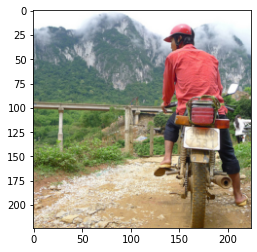

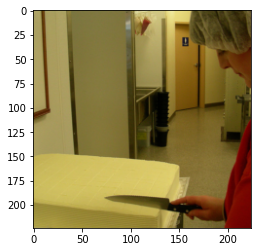

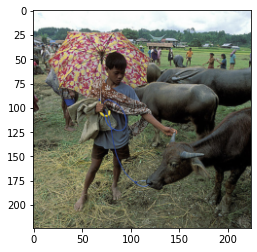

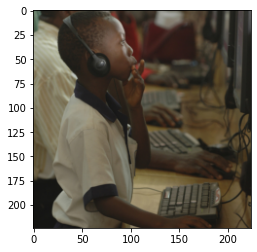

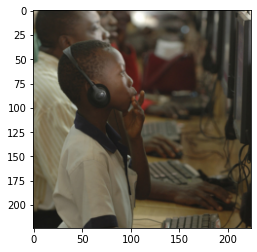

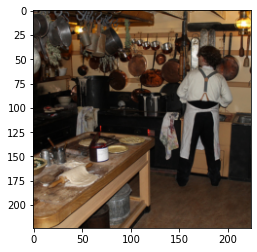

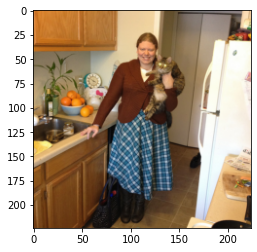

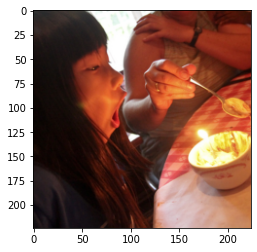

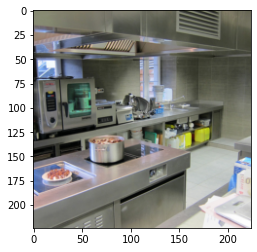

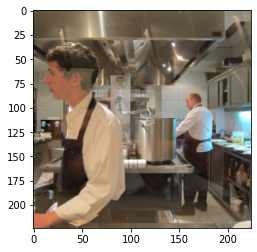

In [ ]:
softmax = nn.Softmax()
for image_id in val_ids[:10]:
    print(image_id)
    # Load/preprocess the image.
    img = load_image(val_id_to_file[image_id])
    # Display the image.
    # -- Your code goes here --
    temp=torch.squeeze(img.permute(2,3,1,0)) #channel should
    #be at the last 224*224*3
    plt.figure()
    plt.imshow(temp)
    # Print all of the category labels for this image.
    # -- Your code goes here --
    for i,category in enumerate(val_id_to_categories[image_id]):
      print((category_to_name[category]))

    # Run the image through the model and softmax.
    label_likelihoods = softmax(vgg_model(img.cuda())).squeeze()

    # Get the top 5 labels, and their corresponding likelihoods.
    probs, indices = label_likelihoods.topk(5)

    # Iterate and print out the predictions.
    for i in indices:
      print(imagenet_categories[i])
    
    print("\n")
    # -- Your code goes here --

# 3. Computing Generic Visual Features using CNN

Since, rather than the output of VGG, we want a fixed sized vector representation of each image, we remove the last linear layer. The implementation of the forward function for VGG is shown below:

```
x = self.features(x)
x = x.view(x.size(0), -1)
x = self.classifier(x)
```
We aim to preserve everything but the final component of the classifier, meaning we must define an alternative equivalent to `self.classifier`.

In [ ]:
class VGG2(nn.Module):
  def __init__(self):
        super(VGG2, self).__init__()
        self.vgg = models.vgg16(pretrained=True).cuda()
        self.vgg.classifier = nn.Sequential(*[vgg_model.classifier[i] for i in range(4)])


  def forward(self, images):
      x=self.vgg.features(images.cuda())
      #x=self.vgg.avgpool(x)
      out = x.view(x.size(0), -1)
      return  self.vgg.classifier(out)


In [ ]:
# First we vectorize all of the features of training images and write the results to a file.
vgg2=VGG2()
!mkdir -p drive/MyDrive/Colab_Notebooks/CPSC532S/Assignment2/outputs
#f=open('outputs/training_vectors',"w")
# -- Your code goes here --
training_vectors=np.zeros((5000, 4096))
i=0
vgg2.train()
for image_id in train_ids[:5000]:
  img = load_image(train_id_to_file[image_id])
  out=vgg2.forward(img)
  temp_vectors=out.cpu().detach().numpy()

  training_vectors[i,:]=temp_vectors
  i=i+1

In [ ]:
np.save(open('drive/MyDrive/Colab_Notebooks/CPSC532S/Assignment2/outputs/training_vectors', 'wb+'), training_vectors)

In [ ]:
#f=open('outputs/validation_vectors',"w")
# -- Your code goes here --
vgg2.eval()

validation_vectors=np.zeros((100, 4096))
i=0
for image_id in val_ids[:100]:
  img = load_image(val_id_to_file[image_id])
  out=vgg2.forward(img)
  temp_vectors=out.cpu().detach().numpy()
  validation_vectors[i,:]=temp_vectors
  i=i+1
  
np.save(open('drive/MyDrive/Colab_Notebooks/CPSC532S/Assignment2/outputs/validation_vectors', 'wb+'), validation_vectors)

# 4. Visual Similarity

We now use the generated vectors, to find the closest training image for each validation image. This can easily be done by finding the training vector that minimizes the Euclidean distance for every validation image. We repeat this exercise for the first 10 images in the validation set.

In [ ]:

# -- Your code goes here --
validation_vectors = np.load('drive/MyDrive/Colab_Notebooks/CPSC532S/Assignment2/outputs/validation_vectors')
training_vectors = np.load('drive/MyDrive/Colab_Notebooks/CPSC532S/Assignment2/outputs/training_vectors')

ind=list()
for i in range(10):
  val_vec=validation_vectors[i]
  distances=list()
  for j in range(5000):
    temp=np.linalg.norm(val_vec-training_vectors[j]) # eculidan distance
    distances.append(temp)
  ind.append(np.argmin(distances))

[210570, 414738, 404533, 76882, 185326, 166465, 147753, 235031, 229962, 415232]


<Figure size 432x288 with 0 Axes>

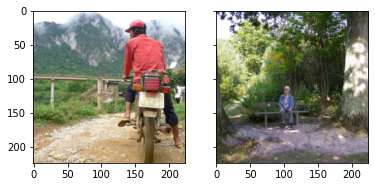

<Figure size 432x288 with 0 Axes>

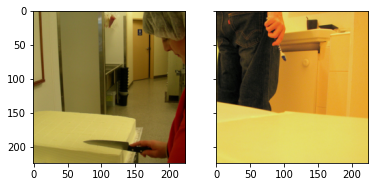

<Figure size 432x288 with 0 Axes>

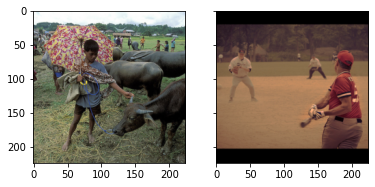

<Figure size 432x288 with 0 Axes>

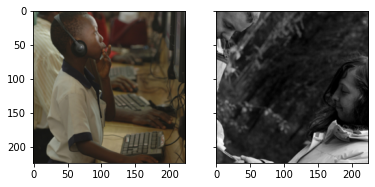

<Figure size 432x288 with 0 Axes>

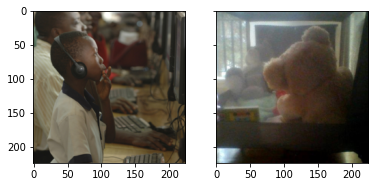

<Figure size 432x288 with 0 Axes>

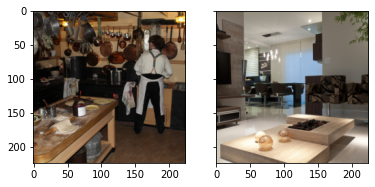

<Figure size 432x288 with 0 Axes>

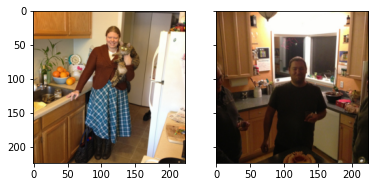

<Figure size 432x288 with 0 Axes>

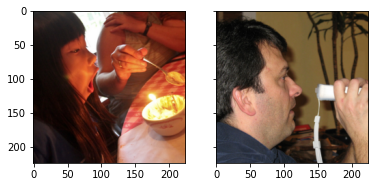

<Figure size 432x288 with 0 Axes>

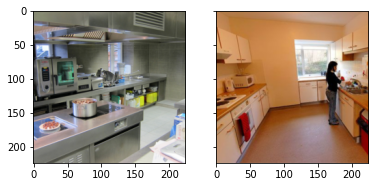

<Figure size 432x288 with 0 Axes>

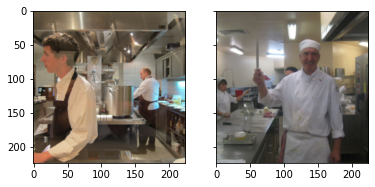

In [ ]:
#test the output
train_id=[train_ids[i] for i in ind]
print(train_id)

for i in range(10):
  img = load_image(val_id_to_file[val_ids[i]])
  temp=torch.squeeze(img.permute(2,3,1,0)) #nearest plot

  img2=load_image(train_id_to_file[train_id[i]])
  #img = load_image(train_id_to_file[])
  temp2=torch.squeeze(img2.permute(2,3,1,0)) #nearest plot

  
  plt.figure(); 
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
  ax1.imshow(temp)
  ax2.imshow(temp2)

# 5. Training a Multi-Label Classification Network

We now build a two layer classification network, which takes 4096-dimensional vectors as input and outputs the probabilities of the 80 categories present in MSCOCO. 

For this purpose, we utilize two layers (both containing sigmoid activation functions) with the hidden dimension set to 512. 

In [ ]:
# First we construct a class for the model
# -- Your code goes here --
#modfied from 
#https://github.com/bentrevett/pytorch-practice/blob/master/2.%20Two%20Hidden%20Layers%20Neural%20Network.ipynb
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        
        self.Sigmoid = nn.Sigmoid()
        
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, 80),
            # nn.Sigmoid(),
        )
        

    def forward(self, x):
        x1 = self.Sigmoid(self.i2h(x))
        x2=self.h2o(x1)
        #x2 = self.Sigmoid(self.h2o(x1))
        return x2


# instantiate the model
model = Net(4096, 512, 80)

# print model architecture
print(model)

Net(
  (i2h): Linear(in_features=4096, out_features=512, bias=True)
  (h2o): Linear(in_features=512, out_features=80, bias=True)
  (Sigmoid): Sigmoid()
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=512, out_features=80, bias=True)
  )
)


In [ ]:
# The output data is prepared by representing each output as a binary vector of categories
# -- Your code goes here --
import torch.optim as optim

In [ ]:
def get_target(train_id):
    #y = np.zeros((num_classes))
    categories=train_id_to_categories[train_id]
    index=[category_to_idx[c] for c in categories]
    y = np.zeros(len(category_to_idx))
    y[index]=1
    #y=y.reshape((1,num_classes))
    return y



In [ ]:

import torch.utils.data as data
training_vectors = np.load('drive/MyDrive/Colab_Notebooks/CPSC532S/Assignment2/outputs/training_vectors')

class PlanarDataset(data.Dataset):
    def __init__(self, num_examples=500):
        ## Function to initialize the dataset class
        self.X = training_vectors[range(num_examples), ]
        self.Y = np.array([get_target(train_id) for train_id in train_ids])[range(num_examples)]

    def __getitem__(self, index):
        ## Return a data point given an index. Convert numpy array to Pytorch Tensor.
        return torch.from_numpy(self.X[index,:],).type(torch.FloatTensor), torch.from_numpy(self.Y[index,:]).type(torch.FloatTensor)

    def __len__(self):
        ## Return the length of the dataset
        return self.X.shape[0]
    
    def get_all_data(self):
      ## Return all the data. Not something you would do for large datasets. Just used here for convenience of visualization
      return self.X.T, self.Y.T



In [ ]:
#from prompt_toolkit.key_binding.bindings.named_commands import yank
#planarDataObj = PlanarDataset()
#X, Y = planarDataObj.get_all_data()
planarDataObj = PlanarDataset(num_examples=5000)
dataset_size = planarDataObj.__len__()
criterion=nn.MultiLabelSoftMarginLoss()

def train(model, learning_rate=0.001,batch_size=50, epochs=2):
    data_size=5000

    #num_batches=np.int(data_size/batch_size) #put as integer
    optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
  #optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9)
    
    train_loader = torch.utils.data.DataLoader(planarDataObj, batch_size=batch_size, shuffle=True) ## Shuffle will randomly shuffle the data
    test_loader = torch.utils.data.DataLoader(planarDataObj, batch_size=batch_size, shuffle=False)
    model.train()
    #criterion = nn.MultiLabelSoftMarginLoss()
    for e in range(epochs):
      running_loss = 0.0
      #plot_correct = []
      for iter, data in enumerate(train_loader):
        input,target = data
  
        # Reset gradient
        optimizer.zero_grad()
      
        # Forward
        output = model(input)  
        loss = criterion(output,target)

        running_loss += loss.item()
        #loss = criterion(fx, y)

        # Backward
        loss.backward()

        # Update parameters
        optimizer.step()
        
        #loss += train(net, criterion, optimizer, trX[start:end], trY[start:end])
        #correct = predict(model, input, target)
        #plot_correct.append(correct/data_size*100)
      if (e+1) % 1 == 0: print('epoch[%d] = %.8f' % (e, running_loss/dataset_size))

    
  

In [ ]:

net = Net(4096, 512, 80)
train(net, learning_rate=0.001, batch_size=50, epochs=20)


epoch[0] = 0.00302485
epoch[1] = 0.00247112
epoch[2] = 0.00228944
epoch[3] = 0.00214980
epoch[4] = 0.00204190
epoch[5] = 0.00194769
epoch[6] = 0.00186218
epoch[7] = 0.00178736
epoch[8] = 0.00171913
epoch[9] = 0.00165883
epoch[10] = 0.00160163
epoch[11] = 0.00155803
epoch[12] = 0.00151165
epoch[13] = 0.00146970
epoch[14] = 0.00143745
epoch[15] = 0.00139824
epoch[16] = 0.00136829
epoch[17] = 0.00133404
epoch[18] = 0.00130143
epoch[19] = 0.00126749


In [ ]:
!mkdir -p drive/MyDrive/Colab_Notebooks/CPSC532S/Assignment2/models
torch.save(net.state_dict(), 'drive/MyDrive/Colab_Notebooks/CPSC532S/Assignment2/models/net')

In [ ]:
# Now repeat step two using the two layer classifier.
# -- Your code goes here --
net.eval()
j=0
for image_id in val_ids[:10]:
    #print(image_id)
    print("the image id is", image_id,"\n")
    # Load/preprocess the image.
    img = load_image(val_id_to_file[image_id])
    # Display the image.
    # -- Your code goes here --
    temp=torch.squeeze(img.permute(2,3,1,0)) #channel should
    #be at the last 224*224*3
    # plt.figure()
    # plt.imshow(temp)
    # Print all of the category labels for this image.
    # -- Your code goes here --
    for i,category in enumerate(val_id_to_categories[image_id]):
      print((category_to_name[category]))
    print("\n")
    # Run the image through the model and softmax.
    #label_likelihoods = softmax(vgg_model(img.cuda())).squeeze()
    val_vec=torch.from_numpy(validation_vectors[j,:]).type(torch.FloatTensor)
    #label_likelihoods = net(val_vec)
    label_likelihoods = net(val_vec)
    j=j+1
    
    # Get the top 5 labels, and their corresponding likelihoods.
    probs, indices = label_likelihoods.topk(5)
    
    # Iterate and print out the predictions.
    print("predicted 5-objects\n")
    for i in indices:
      print(category_idx_to_name[i])
    
    print("\n")

    # -- Your code goes here --

the image id is 391895 

person
bicycle
motorcycle


predicted 5-objects

person
bench
elephant
car
skateboard


the image id is 522418 

sink
person
cake
knife


predicted 5-objects

person
chair
toilet
sink
bed


the image id is 184613 

person
umbrella
cow


predicted 5-objects

person
horse
frisbee
cow
dog


the image id is 318219 

tv
person
mouse
keyboard


predicted 5-objects

person
cell phone
handbag
dog
skateboard


the image id is 554625 

tv
person
mouse
keyboard


predicted 5-objects

person
dog
handbag
cell phone
tie


the image id is 397133 

person
dining table
bottle
oven
cup
knife
spoon
bowl
sink
broccoli
carrot


predicted 5-objects

dining table
person
chair
cup
bowl


the image id is 574769 

potted plant
person
bottle
oven
cat
refrigerator
spoon
bowl
clock
sink
orange
handbag


predicted 5-objects

person
bottle
cup
chair
knife


the image id is 60623 

person
dining table
wine glass
spoon
bowl


predicted 5-objects

person
dining table
pizza
cup
knife


the image

From the output, the predicted objects are not bad. Most of the predicted lables include person, which indiates the frequency of appearing those objects in first 5000 samples is high (I only use the first 5000 samples for training stage). That indicates the outputs from transfer learning can be some informative input for the two layer neural network. The reason why this model performs not that good is we adpot the optimal weights from vgg16 directly and only train the last few classifier layers. If we train the whole network on the MS-COCO dataset, the performance will be expect to improve since the weights will be adjusted.

In [ ]:
# for name, param in net.named_parameters():
#     if param.requires_grad:
#         print (name, param.data)

# 6. End-to-End Model Fine-tuning

Instead of training *only* the final two layers, we now create an end-to-end model and train the entire thing. 

In [ ]:
torch.cuda.empty_cache()


In [ ]:
# First we construct a class for the model
#keep
import torch
device = torch.device('cuda:0')
net.load_state_dict(torch.load('drive/MyDrive/Colab_Notebooks/CPSC532S/Assignment2/models/net'))
net.train()

class VGG3(nn.Module):
  def __init__(self):
        super(VGG3, self).__init__()
        self.vgg = models.vgg16(pretrained=True).to(device)
        # for param in self.vgg.parameters():
        #     param.requires_grad = True
        self.vgg.classifier = nn.Sequential(
            *[models.vgg16(pretrained=True).classifier[i] for i in range(6)],
            *net.classifier).to(device)
        

  def forward(self, images):
      x=self.vgg.features(images.cuda())
      #x=self.vgg.avgpool(x)
      out = x.view(x.size(0), -1)
      return  self.vgg.classifier(out).to(device)


In [ ]:
#load the orginal dataset 
class PlanarDataset2(data.Dataset):
    def __init__(self,num_examples=400):
        ## Function to initialize the dataset class
        #self.X = np.array([torch.squeeze(load_image(train_id_to_file[train_id])).detach().numpy() for train_id in train_ids[0:num_examples]])
        self.X = [load_image(train_id_to_file[train_id]).squeeze() for train_id in train_ids[0:num_examples]]
        self.Y = np.array([get_target(train_id) for train_id in train_ids[0:num_examples]])

    def __getitem__(self, index):
        ## Return a data point given an index. Convert numpy array to Pytorch Tensor.
        #return torch.from_numpy(self.X[index,:],).type(torch.FloatTensor), torch.from_numpy(self.Y[index,:]).type(torch.FloatTensor)
        return self.X[index].type(torch.FloatTensor), torch.from_numpy(self.Y[index,:]).type(torch.FloatTensor)

    def __len__(self):
        ## Return the length of the dataset
        #return self.X.shape[0]
        return len(self.X)
    
    def get_all_data(self):
      ## Return all the data. Not something you would do for large datasets. Just used here for convenience of visualization

      return self.X, self.Y

In [ ]:

planarDataObj = PlanarDataset2(num_examples=5000)
#planarDataObj = PlanarDataset2()
dataset_size = planarDataObj.__len__()
print(dataset_size)
#X, Y = planarDataObj.get_all_data()


def train2(model, learning_rate=0.001, batch_size=50, epochs=2):
    """
    Training function which takes as input a model, a learning rate and a batch size.
  
    After completing a full pass over the data, the function exists, and the input model will be trained.
    """
   # data_size=5000
    
    #num_batches=np.int(data_size/batch_size) #put as integer
    criterion=nn.MultiLabelSoftMarginLoss()

    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    
    train_loader = torch.utils.data.DataLoader(planarDataObj, batch_size=batch_size, shuffle=True) ## Shuffle will randomly shuffle the data
    test_loader = torch.utils.data.DataLoader(planarDataObj, batch_size=batch_size, shuffle=False)
    
    criterion = nn.MultiLabelSoftMarginLoss()

    model.train()
    for e in range(epochs):
      running_loss = 0.0
      for iter, data in enumerate(train_loader):
    
        input, target = data
        input2=input.squeeze().to(device)
        target=target.to(device)
        #input, target = input.to(device), target.to(device)
        
        optimizer.zero_grad()
      
        # Forward
        output = model(input2)  
       
        loss = criterion(output,target)

        running_loss += loss.item()
        # Backward
        loss.backward()
        # Update parameters
        optimizer.step()
        
      if (e+1) % 1 == 0: print('epoch[%d] = %.8f' % (e, running_loss/dataset_size))
      #writer.add_scalar("Loss/train", running_loss/dataset_size, e)
    #writer.add_scalar("Accuracy", total_correct/ dataset_size, e)
#train(model,learning_rate=0.001,batch_size=2,epochs=10)
# Finally train the model

5000


In [ ]:
5# Now repeat step two using the end-to-end classifier.
# -- Your code goes here --
model=VGG3()

In [ ]:
train2(model,learning_rate=0.0001,batch_size=50,epochs=5)

epoch[0] = 0.00543965
epoch[1] = 0.00301423
epoch[2] = 0.00278981
epoch[3] = 0.00274389
epoch[4] = 0.00273183


In [ ]:

model.eval()

for image_id in val_ids[:10]:
    #print(image_id)
    
    print("the image id is", image_id,"\n")
    # Load/preprocess the image.
    img = load_image(val_id_to_file[image_id]).to(device)
    # Display the image.
    # -- Your code goes here --
    #temp=torch.squeeze(img) #channel should
    # print(temp.size())
    
    #plt.figure()
    #plt.imshow(temp)
    # Print all of the category labels for this image.
    # -- Your code goes here --
    for i,category in enumerate(val_id_to_categories[image_id]):
      print((category_to_name[category]))
    print("\n")
    # Run the image through the model and softmax.
    j=j+1
    label_likelihoods=model(img).squeeze()
    # Get the top 5 labels, and their corresponding likelihoods.
    probs, indices = label_likelihoods.topk(5)
    
    indices=indices.view(-1)
    # print("indices")
    print(indices)
    
    # #Iterate and print out the predictions.
    # print("predicted 5-objects\n")

    for i in indices:
      #print(indices[i,:])
      print(category_idx_to_name[i])
    
    print("\n")

    #-- Your code goes here --

the image id is 391895 

person
bicycle
motorcycle


tensor([ 0,  2, 56, 60, 41], device='cuda:0')
person
car
chair
dining table
cup


the image id is 522418 

sink
person
cake
knife


tensor([ 0,  2, 56, 60, 41], device='cuda:0')
person
car
chair
dining table
cup


the image id is 184613 

person
umbrella
cow


tensor([ 0,  2, 56, 60, 41], device='cuda:0')
person
car
chair
dining table
cup


the image id is 318219 

tv
person
mouse
keyboard


tensor([ 0,  2, 56, 60, 41], device='cuda:0')
person
car
chair
dining table
cup


the image id is 554625 

tv
person
mouse
keyboard


tensor([ 0,  2, 56, 60, 41], device='cuda:0')
person
car
chair
dining table
cup


the image id is 397133 

person
dining table
bottle
oven
cup
knife
spoon
bowl
sink
broccoli
carrot


tensor([ 0,  2, 56, 60, 41], device='cuda:0')
person
car
chair
dining table
cup


the image id is 574769 

potted plant
person
bottle
oven
cat
refrigerator
spoon
bowl
clock
sink
orange
handbag


tensor([ 0,  2, 56, 60, 41], device='cud

In [ ]:
import gc
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

7. Hyper-parameter Tuning

Now we do a grid search over the learning rate and batch size.

In [ ]:
planarDataObj = PlanarDataset2(num_examples=50)
dataset_size = planarDataObj.__len__()
criterion = nn.MultiLabelSoftMarginLoss()

In [ ]:
# -- Your code goes here --
def hyperparam_tune(model,learning_rate, batch_size,epochs=2):
    train_loader = torch.utils.data.DataLoader(planarDataObj, batch_size=batch_size, shuffle=True) ## Shuffle will randomly shuffle the data
    test_loader = torch.utils.data.DataLoader(planarDataObj, batch_size=batch_size, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train() 
    train_loss=[]
    validation_loss=[]
    for epoch in range(epochs):
      print("epoch",epoch)
      running_loss=0.0
      val_running_loss=0.0
      for iter, data in enumerate(train_loader):

        input, target = data
        input2=input.squeeze().to(device)
        target=target.to(device)
        #input, target = input.to(device), target.to(device)
        
        optimizer.zero_grad()
      
        # Forward
        output = model(input2)  
       
        loss = criterion(output,target)

        running_loss += loss.item()
        #print("loss in epoch",epoch)
        #print(running_loss)
        loss.backward()
        optimizer.step()
     
      train_loss.append(running_loss/dataset_size)
      
      for val_id in val_ids:
        # Load/preprocess the image.
        input = load_image(val_id_to_file[val_id]).to(device)
        target = torch.tensor(get_target(val_id))
        target=target.to(device)
        # Run the image through the model and softmax.
        out = model(input)
        val_loss = criterion(out, target)
        val_running_loss += val_loss.item()
        # Get the top 5 labels, and their corresponding likelihoods.
        probs, indices = label_likelihoods.topk(5)
      validation_loss.append(val_running_loss/len(val_ids))
    
    #x = np.linspace(0, 10, 1000)
    fig, ax = plt.subplots()  
    plt.xlabel('# of epoches')
    plt.title("train_loss/val_loss with Learning rate =" + str(learning_rate)
              +" batch size="+str(batch_size))
    ax.plot(np.arange(1,epochs+1), np.squeeze(train_loss), '-b', label='train_loss/train_size')
    ax.plot(np.arange(1,epochs+1), np.squeeze(validation_loss), '--r', label='val_loss/val_size')
    leg = ax.legend();
    # plt.plot(np.arange(1,epochs+1),np.squeeze(validation_loss))
    # plt.ylabel('cost')
    # plt.xlabel('# of epoches')
    # plt.title("validation_loss with Learning rate =" + str(learning_rate)
    #           +" batch size="+str(batch_size))
    
    # plt.show()
    print("train_loss for epoches")
    print(train_loss)

    print("validation_loss for epoches")
    print(validation_loss)




learning_rate: 0.0001 batch_size: 25
epoch 0
epoch 1
epoch 2
train_loss for epoches
[0.005653095147013665, 0.00553216592669487, 0.005539355608820915]
validation_loss for epoches
[0.03851980758011631, 0.03879586153845595, 0.038597875773833945]


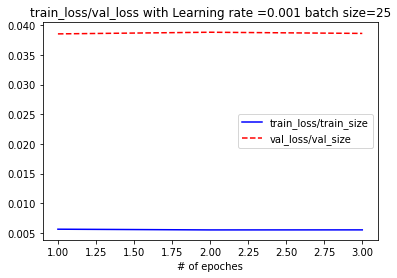

In [ ]:
#due to the gpu memory limit, it is feasiable to write 
#nested for loop, I manully set different combinations 
#of hyper-parameters and compare results
#here is one example 
learning_rate_collection = [1e-3, 1e-4, 1e-5]
batch_size_collection = [25, 50, 100]

model_test=VGG3()
print("learning_rate: {} batch_size: {}".format(1e-4,25))
hyperparam_tune(model_test, learning_rate=1e-3,batch_size=25,epochs=3)


In [ ]:
import gc
model_test.cpu()
del model_test
gc.collect()
torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


learning_rate: 0.0001 batch_size: 50
epoch 0
epoch 1
epoch 2
train_loss for epoches
[0.0014728344976902008, 0.0011296623200178146, 0.0010482805222272872]
validation_loss for epoches
[0.04483034690127805, 0.035506070423052954, 0.053957700933097846]


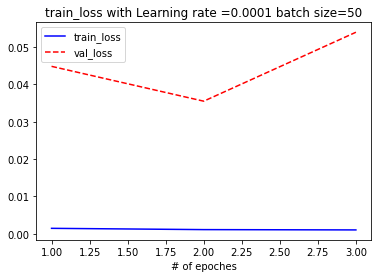

In [ ]:
model_test=VGG3()
print("learning_rate: {} batch_size: {}".format(1e-3,50))
hyperparam_tune(model_test, learning_rate=1e-3,batch_size=50,epochs=3)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


learning_rate: 0.0001 batch_size: 50
epoch 0
epoch 1
epoch 2
train_loss for epoches
[0.0014368075132369996, 0.0010967111587524413, 0.0010168628394603728]
validation_loss for epoches
[0.045302828443542255, 0.03747000311421924, 0.046503828920046765]


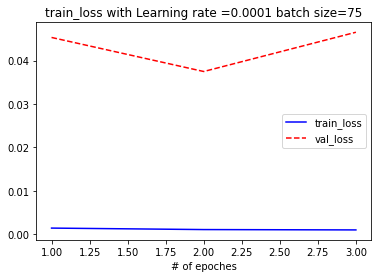

In [ ]:
import gc
model_test.cpu()
del model_test
gc.collect()
torch.cuda.empty_cache()
model_test=VGG3()
print("learning_rate: {} batch_size: {}".format(1e-4,50))
hyperparam_tune(model_test, learning_rate=1e-4,batch_size=75,epochs=3)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


learning_rate: 0.0001 batch_size: 50
epoch 0
epoch 1
epoch 2
train_loss for epoches
[0.0028273312747478484, 0.0025535593181848525, 0.0023566843569278718]
validation_loss for epoches
[0.038732368819291436, 0.03957095798795445, 0.0397262092066453]


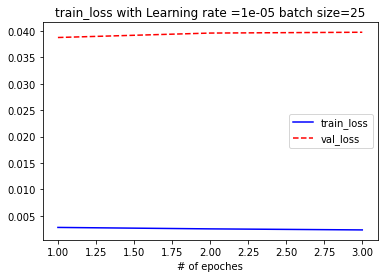

In [ ]:
import gc
model_test.cpu()
del model_test
gc.collect()
torch.cuda.empty_cache()
model_test=VGG3()
print("learning_rate: {} batch_size: {}".format(1e-5,50))
hyperparam_tune(model_test, learning_rate=1e-5,batch_size=25,epochs=3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


learning_rate: 0.0001 batch_size: 50
epoch 0
epoch 1
epoch 2
train_loss for epoches
[0.0014088402688503265, 0.0013337525725364684, 0.001271681785583496]
validation_loss for epoches
[0.03836281298326048, 0.039513942683028304, 0.03992960168656556]


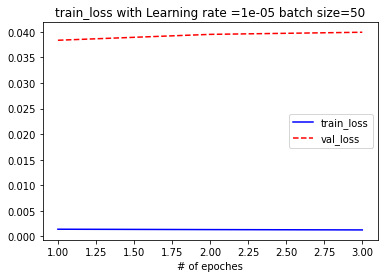

In [ ]:
import gc
model_test.cpu()
del model_test
gc.collect()
torch.cuda.empty_cache()
model_test=VGG3()
print("learning_rate: {} batch_size: {}".format(1e-5,50))
hyperparam_tune(model_test, learning_rate=1e-5,batch_size=50,epochs=3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


learning_rate: 0.0001 batch_size: 50
epoch 0
epoch 1
epoch 2
train_loss for epoches
[0.0014010585844516754, 0.0013335013389587402, 0.0012569747865200042]
validation_loss for epoches
[0.03925126027675468, 0.03944875653479175, 0.03988993178624195]


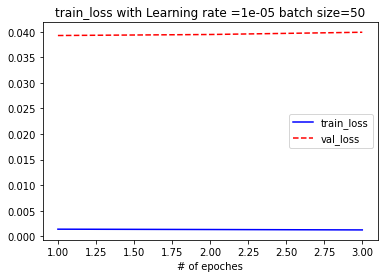

In [ ]:
import gc
model_test.cpu()
del model_test
gc.collect()
torch.cuda.empty_cache()
model_test=VGG3()
print("learning_rate: {} batch_size: {}".format(1e-5,50))
hyperparam_tune(model_test, learning_rate=1e-5,batch_size=50,epochs=3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


learning_rate: 0.0001 batch_size: 50
epoch 0
epoch 1
epoch 2
train_loss for epoches
[0.0014231745898723603, 0.001342170387506485, 0.001273031085729599]
validation_loss for epoches
[0.039086108005311856, 0.03893560922319375, 0.03924190773116653]


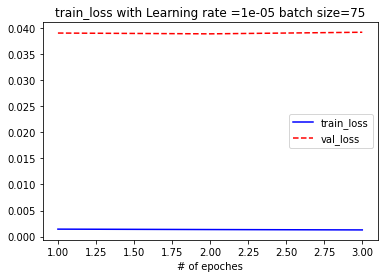

In [ ]:
import gc
model_test.cpu()
del model_test
gc.collect()
torch.cuda.empty_cache()
model_test=VGG3()
print("learning_rate: {} batch_size: {}".format(1e-5,50))
hyperparam_tune(model_test, learning_rate=1e-5,batch_size=75,epochs=3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


learning_rate: 0.0001 batch_size: 50
epoch 0
epoch 1
epoch 2
train_loss for epoches
[0.0028117427229881285, 0.0028276795148849485, 0.002753377705812454]
validation_loss for epoches
[0.03873806855294514, 0.0392434227697322, 0.03878723738973439]


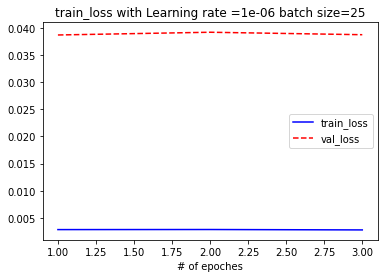

In [ ]:
import gc
model_test.cpu()
del model_test
gc.collect()
torch.cuda.empty_cache()
model_test=VGG3()
print("learning_rate: {} batch_size: {}".format(1e-6,50))
hyperparam_tune(model_test, learning_rate=1e-6,batch_size=25,epochs=3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


learning_rate: 1e-06 batch_size: 50
epoch 0
epoch 1
epoch 2
train_loss for epoches
[0.0014216533303260802, 0.001389687806367874, 0.0013826346397399901]
validation_loss for epoches
[0.03937254343144514, 0.03846078181627671, 0.039047696519583036]


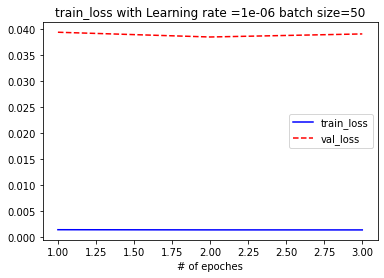

In [ ]:
import gc
model_test.cpu()
del model_test
gc.collect()
torch.cuda.empty_cache()
model_test=VGG3()
print("learning_rate: {} batch_size: {}".format(1e-6,50))
hyperparam_tune(model_test, learning_rate=1e-6,batch_size=50,epochs=3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


learning_rate: 1e-06 batch_size: 75
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
train_loss for epoches
[0.0013900725543498993, 0.001397632211446762, 0.0013925783336162568, 0.0013766875863075257, 0.0013711915910243988, 0.0013701768219470977, 0.0013540609180927277, 0.0013412857055664063, 0.001343827247619629, 0.0013333939015865326, 0.0013222146034240724, 0.0013189779222011566, 0.0013166554272174835, 0.0013191702961921693, 0.001293589323759079, 0.001300436556339264, 0.0012808649241924286, 0.001273939460515976, 0.0012660980224609374, 0.0012714986503124237]
validation_loss for epoches
[0.03834605828671057, 0.03898519054582085, 0.03911678094967464, 0.03873493039181675, 0.03863823168394991, 0.03932741350829382, 0.038906207642916794, 0.03883454506135423, 0.039231335411502644, 0.03916352800842061, 0.038907365193836536, 0.03901963379530936, 0.03865307360184851, 0.03933253

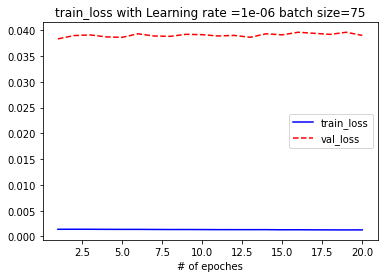

In [ ]:
import gc
model_test.cpu()
del model_test
gc.collect()
torch.cuda.empty_cache()
model_test=VGG3()
print("learning_rate: {} batch_size: {}".format(1e-6,75))
hyperparam_tune(model_test, learning_rate=1e-6,batch_size=75,epochs=20)